In [241]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import time
import math
from math import radians
import gc
import seaborn as sns
from matplotlib import pyplot
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from IPython.core.display import HTML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/totalrolling8/total_rolling.parquet
/kaggle/input/totalrolling10/total_rolling.parquet
/kaggle/input/nfl-big-data-bowl-2023/players.csv
/kaggle/input/nfl-big-data-bowl-2023/week6.csv
/kaggle/input/nfl-big-data-bowl-2023/week2.csv
/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv
/kaggle/input/nfl-big-data-bowl-2023/week3.csv
/kaggle/input/nfl-big-data-bowl-2023/week8.csv
/kaggle/input/nfl-big-data-bowl-2023/games.csv
/kaggle/input/nfl-big-data-bowl-2023/week5.csv
/kaggle/input/nfl-big-data-bowl-2023/week7.csv
/kaggle/input/nfl-big-data-bowl-2023/week1.csv
/kaggle/input/nfl-big-data-bowl-2023/week4.csv
/kaggle/input/nfl-big-data-bowl-2023/plays.csv
/kaggle/input/bdb2023-finaldata-7/FinalData_Week6.parquet
/kaggle/input/bdb2023-finaldata-7/FinalData_Week8.parquet
/kaggle/input/bdb2023-finaldata-7/FinalData_Week7.parquet
/kaggle/input/bdb2023-finaldata-7/FinalData_Week1.parquet
/kaggle/input/bdb2023-finaldata-7/FinalData_Week3.parquet
/kaggle/input/bdb2023-finaldata-7

In [2]:
def get_df_counts(df: pd.DataFrame):
    """get the number of unique counts for each column"""
    total_count = len(df)
    df_unique = pd.DataFrame.from_records([(col, str(df[col].dtype), df[col].count(), total_count-df[col].count(), df[col].nunique()) for col in df.columns],
                                          columns=['column_name', 'dtype', 'non_null_count', 'null_count', 'num_unique'])
    mem = df.memory_usage()
    mem_usage = pd.DataFrame(mem, columns=['usage']).reset_index().rename(columns={'index': 'column_name'})
    mem_usage = mem_usage.assign(usage_mb = mem_usage.usage/1024**2)
    mem_usage.drop(columns=['usage'], inplace=True)
    df_counts = mem_usage.merge(df_unique).sort_values(by='usage_mb', ascending=False)
    
    print(f'memory usage: {sum(mem)/1024**2:.1f}MB')
    return df_counts

def reduce_mem_usage(df, category_limit: int = 128):
    """reduce memory usage"""
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            if not (str(col_type).startswith('int') or str(col_type).startswith('float')):
                continue
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type).startswith('float'):
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)#
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             if df[col].nunique() <= category_limit:
#                 df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'memory usage decreased by {100*(start_mem - end_mem)/start_mem:.1f}, final size {end_mem:.1f} MB')

    return df

In [3]:
def ball_snap_throw_frames(D_frame):
    D_frame_unique = D_frame.drop_duplicates('frameId')
    default = 20
    snap_frame = D_frame.query('event == "ball_snap"').drop_duplicates('frameId').frameId
    if len(snap_frame) == 1:
        D_frame['ball_snap'] = snap_frame.item()
    ending_frames = [1000.5]
    pass_frame_df = D_frame.query('event == "pass_forward"').drop_duplicates('frameId').frameId
    if len(pass_frame_df) == 1:
        pass_forward = pass_frame_df.item()
        D_frame['pass_forward'] = pass_forward
        ending_frames.append(pass_forward)
    
    run_frame_df = D_frame.query('event == "run"').drop_duplicates('frameId').frameId
    if len(run_frame_df) == 1:
        run_frame = run_frame_df.item()
        ending_frames.append(run_frame)
    
    sack_frame_df = D_frame.query('event == "qb_sack"').drop_duplicates('frameId').frameId
    if len(sack_frame_df) == 1:
        sack_frame = sack_frame_df.item()
        ending_frames.append(sack_frame)
    
    strip_frame_df = D_frame.query('event == "qb_strip_sack"').drop_duplicates('frameId').frameId
    if len(strip_frame_df) == 1:
        strip_frame = strip_frame_df.item()
        ending_frames.append(strip_frame)
    
    fumble_frame_df = D_frame.query('event == "fumble"').drop_duplicates('frameId').frameId
    if len(fumble_frame_df) == 1:
        fumble_frame = fumble_frame_df.item()
        ending_frames.append(fumble_frame)

    end_frame = min(ending_frames)
    

    D_frame['end_frame'] = end_frame
    return D_frame

In [4]:
def event_frames(D):
    D = D.groupby(['gameId','playId']).apply(func = ball_snap_throw_frames)
    D.ball_snap.fillna(D.ball_snap.mean(), inplace = True)
    D.ball_snap = D.ball_snap.round()
    return D

In [6]:
def rolling_o(df):
    spin_length = 8
    df['rolling_o'] = df.real_change_o.rolling(8).sum().shift(-1*spin_length + 1)    return df

In [7]:
def GreatestRolling(D):
    D_relevant = D[(D.frameId > D.ball_snap + 6) & (D.frameId < D.end_frame)]
    max_rolling = D_relevant.rolling_o.max()
    min_rolling = D_relevant.rolling_o.min()
    if abs(min_rolling) > abs(max_rolling):
        highest_rolling = min_rolling
    else:
        highest_rolling = max_rolling
    D['max_rolling_o'] = highest_rolling
    max_frame = D.query('rolling_o == max_rolling_o').frameId
    if len(max_frame) == 1:
        D['max_rolling_o_frameId'] = max_frame.item()
    elif len(max_frame) > 1:
        D['max_rolling_o_frameId'] = max_frame[:1].item()
    return D

In [8]:
def ChangeDirection2(D):
    frames = 40
    spin_length = 8
    D.loc[D.ball_snap + frames < D.end_frame, 'end_frame'] = D.ball_snap + frames
    D['change_o'] = D.groupby(['gameId','playId','nflId']).o_deg_std.diff()
    #magnitude of change should always be less than 180 degrees
    D['real_change_o'] = D.change_o
    D.loc[D.real_change_o > 180, 'real_change_o'] = (D.real_change_o-360)
    D.loc[D.real_change_o < -180, 'real_change_o'] = (360 + D.real_change_o)
    #rolling o
    D = D.groupby(['gameId','playId','nflId']).apply(func = rolling_o).reset_index(drop = True)
    #get max change and frameId of max change
    D = D.groupby(['gameId','playId','nflId']).apply(func = GreatestRolling).reset_index(drop = True)
    D['abs_max_rolling_o'] = D.max_rolling_o.abs()
    
    return D
    

In [9]:
def overall_prwr(D):
    num_wins = D.query('(pff_sack == 1.0) | (pff_hit == 1.0) | (pff_hurry == 1.0)').shape[0]
    total_plays = D.shape[0]
    D['overall_total_rushes'] = total_plays
    D['overall_prwr'] = num_wins / total_plays
    return D

def overall_pbwr(D):
    num_losses = D.query('(pff_beatenByDefender == 1.0) | (pff_hitAllowed == 1.0) | (pff_hurryAllowed == 1.0) | (pff_sackAllowed == 1.0)').shape[0]
    total_plays = D.shape[0]
    D['overall_total_blocks'] = total_plays
    D['overall_pbwr'] = (total_plays-num_losses)/total_plays
    return D

In [10]:
plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/plays.csv')

In [11]:
edge_positions = ["LE", "LEO", "RE", "REO", "LOLB", "ROLB"]

In [12]:
oline_positions = ["C", "LG", "LT", "RG", "RT", "HB-L", "HB-R", "TE-R", "SLWR", "TE-iR", "TE-iL", 
                   "TE-oL", "HB", "FB-R", "SLiWr", "TE-oR", "FB-L", "LWR", "FB"]

In [13]:
total_rolling_8= pd.read_parquet('/kaggle/input/totalrolling8/total_rolling.parquet')
total_rolling_8 = reduce_mem_usage(total_rolling_8)
total_rolling_8.shape

memory usage decreased by 0.0, final size 4262.4 MB


(7952692, 117)

In [14]:
rush_total_rolling = total_rolling_8.query('pff_role == "Pass Rush"')

rush_total_rolling = rush_total_rolling.groupby('nflId').apply(func = overall_prwr)

In [21]:
rush_total_rolling_high = rush_total_rolling.query('abs_max_rolling_o >= 200')

In [22]:
gc.collect()

39

In [23]:
cleaned_weeks = []
for j in range(0,8):
    print(j)
    current_week = pd.read_parquet('/kaggle/input/bdb2023-finaldata-7/FinalData_Week' + str(j+1) + '.parquet')
    cleaned_weeks.append(current_week)

0
1
2
3
4
5
6
7


In [24]:
total_cleaned_weeks = pd.concat(cleaned_weeks)

In [29]:
rush_total_rolling_merge = rush_total_rolling[['gameId','playId','frameId','nflId','displayName','officialPosition', 'a', 'dis',
    'down', 'yardsToGo', 
    'absoluteYardlineNumber_std','offenseFormation', 'personnelO', 'defendersInBox', 
    'personnelD','dropBackType', 'pff_playAction', 'pff_passCoverage','pff_passCoverageType', 'pff_role', 
    'pff_hit','pff_hurry', 'pff_sack', 'QB_X', 'QB_Y', 'QB_o_rad_std',
    'QB_dir_rad_std', 'QB_dx', 'QB_dy', 'dist_QB', 'football_X',
    'football_Y', 'ball_dx', 'ball_dy', 'dist_ball','ball_snap', 'pass_forward', 'end_frame', 'change_o',
    'real_change_o', 'rolling_o', 'max_rolling_o', 'max_rolling_o_frameId',
    'abs_max_rolling_o','overall_total_rushes', 'overall_prwr',]]

In [30]:
rush_total_rolling_merge.columns = ['blocked_' + str(col) for col in rush_total_rolling_merge.columns]

In [31]:
total_oline_rush_merge = pd.merge(total_cleaned_weeks, rush_total_rolling_merge, how = 'left', left_on=['gameId', 'playId', 'frameId','pff_nflIdBlockedPlayer'], right_on=['blocked_gameId', 'blocked_playId', 'blocked_frameId','blocked_nflId'])

In [37]:
total_oline_rush_merge = total_oline_rush_merge[total_oline_rush_merge.pff_positionLinedUp.isin(oline_positions)]

In [38]:
total_oline_rush_merge = total_oline_rush_merge.groupby('nflId').apply(func = overall_pbwr)

In [40]:
only_total_oline_rush_merge = total_oline_rush_merge.query('blocked_abs_max_rolling_o >= 200')

In [46]:
only_total_oline_rush_merge['diff_a'] = only_total_oline_rush_merge['a'] - only_total_oline_rush_merge['blocked_a']
only_total_oline_rush_merge['diff_speed_x'] = only_total_oline_rush_merge['speed_x'] - only_total_oline_rush_merge['blocked_speed_x']
only_total_oline_rush_merge['diff_speed_y'] = only_total_oline_rush_merge['speed_y'] - only_total_oline_rush_merge['blocked_speed_y']
only_total_oline_rush_merge['diff_QB_dx'] = only_total_oline_rush_merge['QB_dx'] - only_total_oline_rush_merge['blocked_QB_dx']
only_total_oline_rush_merge['diff_QB_dy'] = only_total_oline_rush_merge['QB_dy'] - only_total_oline_rush_merge['blocked_QB_dy']
only_total_oline_rush_merge['diff_dist_QB'] = only_total_oline_rush_merge['dist_QB'] - only_total_oline_rush_merge['blocked_dist_QB']
only_total_oline_rush_merge['diff_ball_dx'] = only_total_oline_rush_merge['ball_dx'] - only_total_oline_rush_merge['blocked_ball_dx']
only_total_oline_rush_merge['diff_ball_dy'] = only_total_oline_rush_merge['ball_dy'] - only_total_oline_rush_merge['blocked_ball_dy']
only_total_oline_rush_merge['diff_dist_ball'] = only_total_oline_rush_merge['dist_ball'] - only_total_oline_rush_merge['blocked_dist_ball']
only_total_oline_rush_merge['diff_dir_deg_std'] = only_total_oline_rush_merge['dir_deg_std'] - only_total_oline_rush_merge['blocked_dir_deg_std']
only_total_oline_rush_merge['a_pct_change'] = only_total_oline_rush_merge['a'].shift(-1).pct_change()
only_total_oline_rush_merge['blocked_a_pct_change'] = only_total_oline_rush_merge['blocked_a'].shift(-1).pct_change()
only_total_oline_rush_merge['abs_diff_speed_x'] = only_total_oline_rush_merge.diff_speed_x.abs()
only_total_oline_rush_merge['abs_diff_speed_y'] = only_total_oline_rush_merge.diff_speed_y.abs()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [48]:
relevant_df = only_total_oline_rush_merge.query('(frameId >= blocked_max_rolling_o_frameId - 5) & (frameId <= blocked_max_rolling_o_frameId + 8)')

In [50]:
def agg_functions(df):
    col_names = ['diff_a','diff_speed_x', 'diff_speed_y', 'diff_QB_dx', 'diff_QB_dy', 'diff_dist_QB',
                'diff_ball_dx', 'diff_ball_dy', 'diff_dist_ball', 'diff_dir_deg_std', 'a_pct_change', 
                 'blocked_a_pct_change','blocked_dx','blocked_dy', 'dist_blocked','dist_los' , 
                 'abs_diff_speed_x', 'abs_diff_speed_y']
    aggs = ['mean','max','min','var']
    for col in col_names:
        for agg in aggs:
            df[col + '_' + agg] = df[col].agg(agg)
        df[col + '_start'] = df[df.frameId == df.blocked_max_rolling_o_frameId][col].item()
    return df

In [51]:
feature_df = relevant_df.groupby(['gameId','playId','nflId']).apply(func = agg_functions)

In [52]:
feature_df = feature_df.replace([np.inf, -np.inf], 0)

In [54]:
feature_df['PressureAllowed'] = np.where(((feature_df.pff_beatenByDefender == 1.0) | 
                                          (feature_df.pff_hitAllowed == 1.0) | (feature_df.pff_hurryAllowed == 1.0) | 
                                          (feature_df.pff_sackAllowed == 1.0) | (feature_df.blocked_pff_hit == 1.0) | 
                                          (feature_df.blocked_pff_hurry == 1.0) | (feature_df.blocked_pff_sack == 1.0)),True,False)

feature_df['blocked_edge'] = np.where(feature_df.blocked_pff_positionLinedUp.isin(edge_positions), 1, 0)

In [72]:
feature_df = feature_df.drop_duplicates(['gameId','playId','nflId'])

In [73]:
group = feature_df[feature_df.blocked_pff_positionLinedUp.isin(edge_positions)]

In [75]:
feature_cols = ['blocked_max_rolling_o','blocked_abs_max_rolling_o','diff_a_mean', 'diff_a_max', 
                'diff_a_min', 'diff_a_var', 'diff_a_start',
               'abs_diff_speed_x_mean', 'abs_diff_speed_x_max',
               'abs_diff_speed_x_min', 'abs_diff_speed_x_var',
               'abs_diff_speed_x_start', 'abs_diff_speed_y_mean',
               'abs_diff_speed_y_max', 'abs_diff_speed_y_min', 'abs_diff_speed_y_var',
               'abs_diff_speed_y_start', 'diff_QB_dx_mean', 'diff_QB_dx_max',
               'diff_QB_dx_min', 'diff_QB_dx_var', 'diff_QB_dx_start',
               'diff_QB_dy_mean', 'diff_QB_dy_max', 'diff_QB_dy_min', 'diff_QB_dy_var',
               'diff_QB_dy_start', 'diff_dist_QB_mean', 'diff_dist_QB_max',
               'diff_dist_QB_min', 'diff_dist_QB_var', 'diff_dist_QB_start',
               'diff_dir_deg_std_mean', 'diff_dir_deg_std_max', 'diff_dir_deg_std_min',
               'diff_dir_deg_std_var', 'diff_dir_deg_std_start', 'a_pct_change_mean',
                'blocked_dx_mean', 'blocked_dx_max',
               'blocked_dx_min', 'blocked_dx_var', 'blocked_dx_start',
               'blocked_dy_mean', 'blocked_dy_max', 'blocked_dy_min', 'blocked_dy_var',
               'blocked_dy_start', 'dist_blocked_mean', 'dist_blocked_max',
               'dist_blocked_min', 'dist_blocked_var', 'dist_blocked_start',
               'dist_los_mean', 'dist_los_max', 'dist_los_min', 'dist_los_var',
               'dist_los_start',
                'blocked_edge'
               ]


In [76]:
feature_cols_2 = [                'blocked_max_rolling_o','blocked_abs_max_rolling_o','diff_a_mean', 'diff_a_max', 
                'diff_a_min', 'diff_a_var', 'diff_a_start',
               'abs_diff_speed_x_mean', 'abs_diff_speed_x_max',
               'abs_diff_speed_x_min', 'abs_diff_speed_x_var',
               'abs_diff_speed_x_start', 'abs_diff_speed_y_mean',
               'abs_diff_speed_y_max', 'abs_diff_speed_y_min', 'abs_diff_speed_y_var',
               'abs_diff_speed_y_start', 'diff_QB_dx_mean', 'diff_QB_dx_max',
               'diff_QB_dx_min', 'diff_QB_dx_var', 'diff_QB_dx_start',
               'diff_QB_dy_mean', 'diff_QB_dy_max', 'diff_QB_dy_min', 'diff_QB_dy_var',
               'diff_QB_dy_start', 'diff_dist_QB_mean', 'diff_dist_QB_max',
               'diff_dist_QB_min', 'diff_dist_QB_var', 'diff_dist_QB_start',
               'diff_dir_deg_std_mean', 'diff_dir_deg_std_max', 'diff_dir_deg_std_min',
               'diff_dir_deg_std_var', 'diff_dir_deg_std_start', 'a_pct_change_mean',
                'blocked_dx_mean', 'blocked_dx_max',
               'blocked_dx_min', 'blocked_dx_var', 'blocked_dx_start',
               'blocked_dy_mean', 'blocked_dy_max', 'blocked_dy_min', 'blocked_dy_var',
               'blocked_dy_start', 'dist_blocked_mean', 'dist_blocked_max',
               'dist_blocked_min', 'dist_blocked_var', 'dist_blocked_start',
               'dist_los_mean', 'dist_los_max', 'dist_los_min', 'dist_los_var',
               'dist_los_start',
                  'blocked_edge'
                 ]

In [80]:
X = feature_df[feature_cols]

In [83]:
X = pd.get_dummies(X)

#impute mean
X[feature_cols_2] = SimpleImputer().fit_transform(X[feature_cols_2])
#standardize data
# X[feature_cols_2] = StandardScaler().fit_transform(X[feature_cols_2])

In [85]:
y = feature_df['PressureAllowed']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12, stratify=y)

In [87]:
spin_model_1 = XGBClassifier(n_estimators = 150, learning_rate = 0.05, max_depth=3,
                        subsample=0.5, objective = "binary:logistic"
                       )

In [88]:
eval_set = [(X_train, y_train), (X_test, y_test)]
spin_model_1.fit(X_train, y_train, early_stopping_rounds=5, eval_metric=['error', 'logloss'], eval_set = eval_set,
          verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [89]:
spin_model_1.score(X_test,y_test)

0.8671328671328671

In [ ]:
predictions = spin_model_1.predict(X_test)
print("Accuracy Score: " + str(accuracy_score(predictions, y_test)))

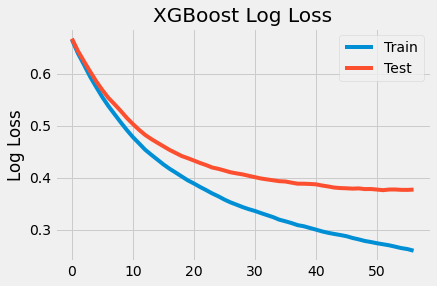

In [90]:
results = spin_model_1.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

In [91]:
imp = {key:importance for key, importance in zip(X.columns, spin_model_1.feature_importances_)}

In [93]:
sorted_features = list(dict(sorted(imp.items(), key= lambda item:item[1], reverse = True)).items())

In [97]:
top_features_df = pd.DataFrame(top_features, columns = ['feature', 'importance'])

In [98]:
top_features_df.sort_values('importance', inplace = True)

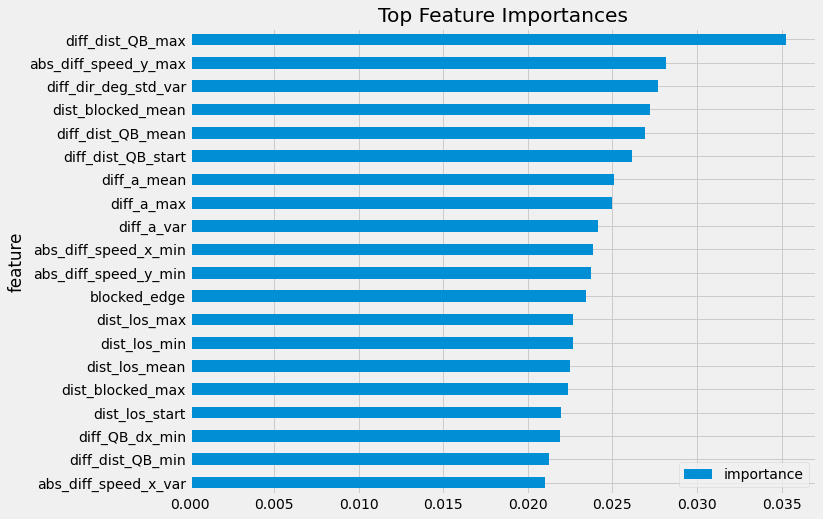

In [100]:
ax = top_features_df.plot(kind='barh', x='feature', y='importance', figsize=(10, 8), 
                          title='Top Feature Importances')

In [104]:
predictions_total = spin_model_1.predict_proba(X)

In [105]:
predictions_total_df = pd.DataFrame(predictions_total, columns =['prob_success', 'prob_fail']) 

In [107]:
X = X.reset_index()

In [108]:
total_score_df = pd.concat([feature_df.reset_index(), predictions_total_df], axis = 1)
# total_score_df = pd.concat([group.reset_index(), predictions_total_df], axis = 1)

In [110]:
total_score_df.to_parquet('/kaggle/working/total_score_df.parquet',index=False)

In [111]:
def spin_rush_win_rate(df):
    num_wins = df.query('PressureAllowed == 1.0').shape[0]
    num_plays = df.shape[0]
    rush_win_rate = num_wins/num_plays
    df['spin_rush_win_rate'] = rush_win_rate
    df['spin_num_wins'] = num_wins
    return df

In [112]:
def spin_block_win_rate(df):
    num_wins = df.query('PressureAllowed == 0.0').shape[0]
    num_plays = df.shape[0]
    rush_win_rate = num_wins/num_plays
    df['spin_block_win_rate'] = rush_win_rate
    df['spin_num_block_wins'] = num_wins
    return df

In [114]:
total_score_df[['grade_blocker']] = MinMaxScaler().fit_transform(total_score_df[['prob_success']])

total_score_df['grade_blocker'] = total_score_df.grade_blocker*100

In [115]:
total_score_df[['grade_rusher']] = MinMaxScaler().fit_transform(total_score_df[['prob_fail']])

total_score_df['grade_rusher'] = total_score_df.grade_rusher*100

In [117]:
avg_block_grade = total_score_df.groupby(['nflId']).grade_blocker.agg('mean')
avg_block_grade = avg_block_grade.rename('avg_block_grade')
avg_rush_grade = total_score_df.groupby(['blocked_nflId']).grade_rusher.agg('mean')
avg_rush_grade = avg_rush_grade.rename('avg_rush_grade')
num_spins_blocked =  total_score_df.groupby('nflId').grade_blocker.agg('count')
num_spins_blocked = num_spins_blocked.rename('num_spins_blocked')
num_spins_rushed = total_score_df.groupby('blocked_nflId').grade_rusher.agg('count')
num_spins_rushed = num_spins_rushed.rename('num_spins_rushed')

In [118]:
total_score_df = total_score_df.merge(avg_block_grade, on = 'nflId')

total_score_df = total_score_df.merge(num_spins_blocked, on = 'nflId')

total_score_df = total_score_df.merge(avg_rush_grade, on = 'blocked_nflId')

total_score_df = total_score_df.merge(num_spins_rushed, on = 'blocked_nflId')

In [ ]:
total_score_df.sort_values('grade_rusher', ascending = False)[['week','gameId','playId','nflId','displayName',
                                                              'pff_positionLinedUp','blocked_pff_positionLinedUp','blocked_displayName',
                                                              'blocked_nflId','blocked_abs_max_rolling_o','blocked_max_rolling_o_frameId',
                                                               'grade_blocker','grade_rusher']].head(20)